In [1]:
# necessary imports
import re
import unicodedata
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tqdm import tqdm
import matplotlib.pyplot as plt
import contractions
import inflect
# from autocorrect import spell
from fuzzywuzzy import fuzz
import gensim

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split, KFold, cross_val_score
from sklearn.metrics import log_loss, make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

from xgboost import XGBClassifier

from gensim.models import KeyedVectors
from scipy.special import expit

%matplotlib inline

In [2]:
stop_words = stopwords.words('english')

In [3]:
# setting paths to the dataset
train = 'data/train.csv'
test = 'data/test.csv'

In [4]:
train_data = pd.read_csv(train)
test_data = pd.read_csv(test)

In [5]:
train_data.head()

id  qid1  qid2                                          question1  \
0   0     1     2  What is the step by step guide to invest in sh...   
1   1     3     4  What is the story of Kohinoor (Koh-i-Noor) Dia...   
2   2     5     6  How can I increase the speed of my internet co...   
3   3     7     8  Why am I mentally very lonely? How can I solve...   
4   4     9    10  Which one dissolve in water quikly sugar, salt...   

                                           question2  is_duplicate  
0  What is the step by step guide to invest in sh...             0  
1  What would happen if the Indian government sto...             0  
2  How can Internet speed be increased by hacking...             0  
3  Find the remainder when [math]23^{24}[/math] i...             0  
4            Which fish would survive in salt water?             0

In [6]:
test_data.head()

test_id                                          question1  \
0        0  How does the Surface Pro himself 4 compare wit...   
1        1  Should I have a hair transplant at age 24? How...   
2        2  What but is the best way to send money from Ch...   
3        3                        Which food not emulsifiers?   
4        4                   How "aberystwyth" start reading?   

                                           question2  
0  Why did Microsoft choose core m3 and not core ...  
1        How much cost does hair transplant require?  
2                      What you send money to China?  
3                                  What foods fibre?  
4                     How their can I start reading?

In [7]:
train_data.shape, test_data.shape

((404290, 6), (2345796, 3))

Over 400000 rows of data to work with. Let's view the number of duplicated questions.

In [14]:
is_duplicate = train_data['is_duplicate'] == 1
is_duplicate.value_counts()

False    255027
True     149263
Name: is_duplicate, dtype: int64

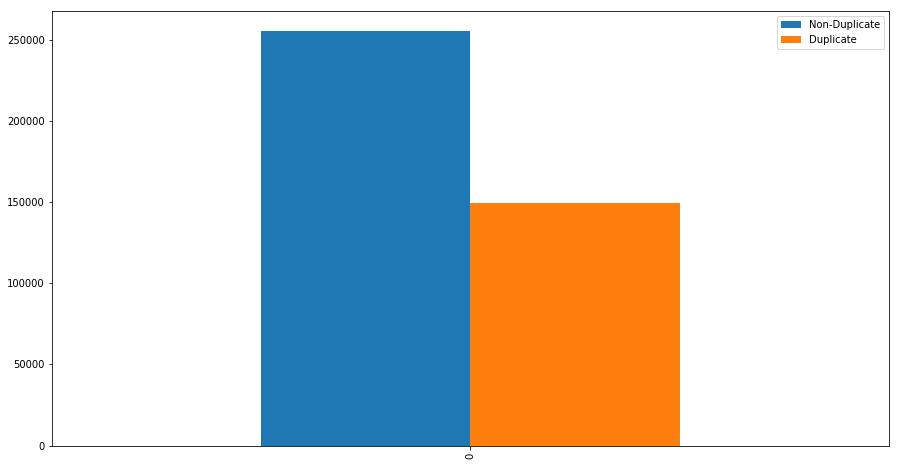

In [15]:
duplicate_df = pd.DataFrame([is_duplicate.value_counts().values[0], is_duplicate.value_counts().values[1]])
duplicate_df.index = ['Non-Duplicate', 'Duplicate']
# duplicate_df.T
duplicate_df.T.plot(kind='bar', figsize=(15,8))

In [17]:
# lets get the percentage of duplicates
percent = (is_duplicate.value_counts().values[1] / train_data.shape[0]) * 100
print(f'The percentage of duplicated question pairs is {percent}%')

The percentage of duplicated question pairs is 36.9197853026293%


**Text Preprocessing**

This the first step to solving the problem at hand. I will consider the following techniques;

*   Noise removal
*   Processing contractions
*   Tokenization
*   Normalization
*   Noise removal


The initial noise removal will be to remove beginning and trailing white spaces if it happens to be the case

In [19]:
# lets make sure none of the questions has beginning and trailing whitespaces
def remove_white_spaces(text):
  '''
  Remove beginning and trailing whitespaces from text
  '''
  return text.strip()

Contractions will also be replaced. For instance "didn't" will become "did not"

In [20]:
# let replace all contractions. for instance "didn't" to "did not"
def replace_contractions(text):
  '''
  Replace contractions in a text
  '''
  return contractions.fix(text)

Next, each question will be tokenized into token.

In [21]:
# next we tokenize each question which is to split the words that make up a question into tokens or split questions into words
def tokenize_words(text):
  '''
  Split questions into words
  '''
  return nltk.word_tokenize(text)

For the normalization stage, a  number of techniques will be used.



*   Lemmatization
*   Remove non-ascii words
*   Replace number symbols with words
*   Convert words to lowercase
*   Remove punctuations

In [22]:
# lemmatization is converting word to it's dictionary base form
def lemmatize(words):
    '''
    Convert words to base dict form
    '''
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

In [23]:
# characters that are non-ascii will be removed
def remove_non_ascii(words):
    '''
    Remove non-ascii characters from list of words
    '''
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

In [24]:
# the number `1` becomes 'one'
def replace_numbers(words):
    '''
    Replace integers in list of words from symbolic form to text form
    '''
    p = inflect.engine()
    new_words = []
    for word in words:
        if word.isdigit():
            new_word = p.number_to_words(word)
            new_words.append(new_word)
        else:
            new_words.append(word)
    return new_words

In [25]:
# convert words to lowercase
def to_lowercase(words):
    '''
    Convert all characters to lowercase
    '''
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

In [26]:
# remove punctuations
def remove_punctuation(words):
    '''
    Remove punctuation from words
    '''
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

In [27]:
def normalize(words):
    words = remove_non_ascii(words)
    words = to_lowercase(words)
    words = remove_punctuation(words)
    words = replace_numbers(words)
    return words

In [28]:
# finally we remove stop words
def remove_stopwords(words):
    '''
    Remove stop words from list of words
    '''
    new_words = []
    for word in words:
        if word not in stop_words:
            new_words.append(word)
    return new_words

In [29]:
# for question1 column
train_data['question1'] = train_data['question1'].apply(lambda text: remove_white_spaces(str(text)))
train_data['question1'] = train_data['question1'].apply(lambda text: replace_contractions(str(text)))
train_data['question1'] = train_data['question1'].apply(lambda text: tokenize_words(text))
train_data['question1'] = train_data['question1'].apply(lambda words: normalize(words))
train_data['question1'] = train_data['question1'].apply(lambda words: lemmatize(words))
train_data['question1'] = train_data['question1'].apply(lambda words: remove_stopwords(words))

# for question2 column
train_data['question2'] = train_data['question2'].apply(lambda text: remove_white_spaces(str(text)))
train_data['question2'] = train_data['question2'].apply(lambda text: replace_contractions(str(text)))
train_data['question2'] = train_data['question2'].apply(lambda text: tokenize_words(text))
train_data['question2'] = train_data['question2'].apply(lambda words: normalize(words))
train_data['question2'] = train_data['question2'].apply(lambda words: lemmatize(words))
train_data['question2'] = train_data['question2'].apply(lambda words: remove_stopwords(words))

In [30]:
train_data.head()

id  qid1  qid2                                          question1  \
0   0     1     2  [step, step, guide, invest, share, market, india]   
1   1     3     4               [story, kohinoor, kohinoor, diamond]   
2   2     5     6  [increase, speed, internet, connection, use, vpn]   
3   3     7     8                          [mentally, lonely, solve]   
4   4     9    10  [one, dissolve, water, quikly, sugar, salt, me...   

                                           question2  is_duplicate  
0         [step, step, guide, invest, share, market]             0  
1  [would, happen, indian, government, steal, koh...             0  
2             [internet, speed, increase, hack, dns]             0  
3  [find, remainder, math, twenty-three, twenty-f...             0  
4                [fish, would, survive, salt, water]             0

In [31]:
unwanted_columns = ['id', 'qid1', 'qid2']
data = train_data.drop(unwanted_columns, axis=1)

In [32]:
data.head()

question1  \
0  [step, step, guide, invest, share, market, india]   
1               [story, kohinoor, kohinoor, diamond]   
2  [increase, speed, internet, connection, use, vpn]   
3                          [mentally, lonely, solve]   
4  [one, dissolve, water, quikly, sugar, salt, me...   

                                           question2  is_duplicate  
0         [step, step, guide, invest, share, market]             0  
1  [would, happen, indian, government, steal, koh...             0  
2             [internet, speed, increase, hack, dns]             0  
3  [find, remainder, math, twenty-three, twenty-f...             0  
4                [fish, would, survive, salt, water]             0

**Featuere Extraction/Engineering**

Here, a number of features will be created from the preprocessed texts.

Metadata

*   length of each question
*   differences in  length
*   common words in each pair of question
*   length of characters in each question
*   length of words in each question

*   string similarity
*   partial string similarity



In [33]:
# text metadata
data['len_q1'] = data['question1'].apply(lambda words: len(words))
data['len_q2'] = data['question2'].apply(lambda words: len(words))
data['diff_len'] = data.len_q1 - data.len_q2
data['common_words'] = data.apply(lambda words: len(set(words['question1']).intersection(set(words['question2']))), axis=1)
data['len_char_q1'] = data['question1'].apply(lambda words: len(set(''.join(words))))
data['len_char_q2'] = data['question2'].apply(lambda words: len(set(''.join(words))))

# fuzzywuzzy
data['ratio'] = data.apply(lambda x: fuzz.ratio(' '.join(x['question1']), ' '.join(x['question2'])), axis=1)
data['partial_ratio'] = data.apply(lambda x: fuzz.partial_ratio(' '.join(x['question1']), ' '.join(x['question2'])), axis=1)
data['token_sort_ratio'] = data.apply(lambda x: fuzz.token_sort_ratio(' '.join(x['question1']), ' '.join(x['question2'])), axis=1)
data['token_set_ratio'] = data.apply(lambda x: fuzz.token_set_ratio(' '.join(x['question1']), ' '.join(x['question2'])), axis=1)
data['qratio'] = data.apply(lambda x: fuzz.QRatio(' '.join(x['question1']), ' '.join(x['question2'])), axis=1)
data['wratio'] = data.apply(lambda x: fuzz.WRatio(' '.join(x['question1']), ' '.join(x['question2'])), axis=1)
data['partial_token_sort_ratio'] = data.apply(lambda x: fuzz.partial_token_set_ratio(' '.join(x['question1']), ' '.join(x['question2'])), axis=1)
data['partial_token_set_ratio'] = data.apply(lambda x: fuzz.partial_token_set_ratio(' '.join(x['question1']), ' '.join(x['question2'])), axis=1)

In [34]:
data.head()

question1  \
0  [step, step, guide, invest, share, market, india]   
1               [story, kohinoor, kohinoor, diamond]   
2  [increase, speed, internet, connection, use, vpn]   
3                          [mentally, lonely, solve]   
4  [one, dissolve, water, quikly, sugar, salt, me...   

                                           question2  is_duplicate  len_q1  \
0         [step, step, guide, invest, share, market]             0       7   
1  [would, happen, indian, government, steal, koh...             0       4   
2             [internet, speed, increase, hack, dns]             0       6   
3  [find, remainder, math, twenty-three, twenty-f...             0       3   
4                [fish, would, survive, salt, water]             0      10   

   len_q2  diff_len  common_words  len_char_q1  len_char_q2  ratio  \
0       6         1             5           15           15     92   
1       9        -5             2           12           20     57   
2       5         1             3           13           12     51   
3       8        -5             0           10           19     20   
4       5         5             2           22           14     43   

   partial_ratio  token_sort_ratio  token_set_ratio  qratio  wratio  \
0            100                92              100      92      95   
1             90                59               84      57      86   
2             56                70               84      51      80   
3             38                20               27      20      41   
4             52                40               51      43      86   

   partial_token_sort_ratio  partial_token_set_ratio  
0                       100                      100  
1                       100                      100  
2                       100                      100  
3                        43                       43  
4                       100                      100

With the new featuers lets can check how wrong the human generated labels are with respect to:

* Difference in question length
* Partial ratio
* Token set ratio

More imformation on the fuzzywuzzy features can be found [here](http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/)

In [37]:
data[data['diff_len'] <= 5]['is_duplicate'].value_counts()

0    242672
1    147990
Name: is_duplicate, dtype: int64

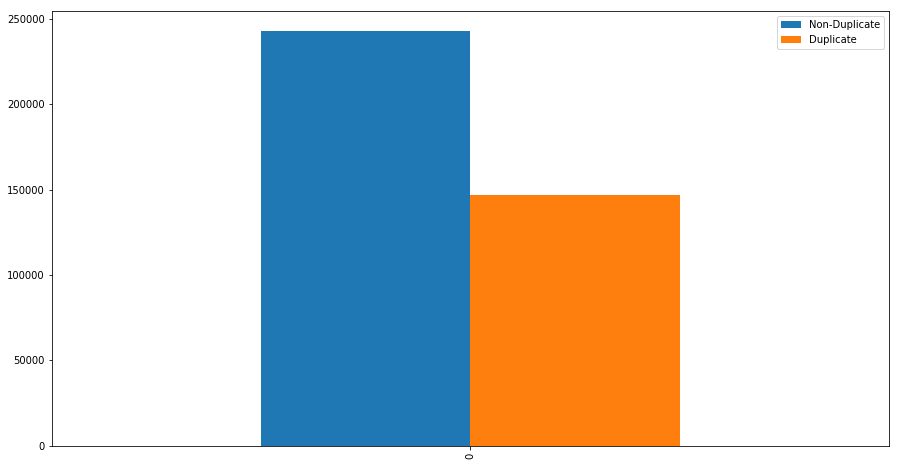

In [35]:
# assuming duplicated questions have a difference in length less than 5
duplicate_df = pd.DataFrame([data[data['diff_len'] <= 5]['is_duplicate'].value_counts().values[0], data[data['diff_len'] < 5]['is_duplicate'].value_counts().values[1]])
duplicate_df.index = ['Non-Duplicate', 'Duplicate']
# duplicate_df.T
duplicate_df.T.plot(kind='bar', figsize=(15,8))

In [29]:
print(data[data['diff_len'] <= 5]['is_duplicate'].value_counts().values[0], data[data['diff_len'] < 5]['is_duplicate'].value_counts().values[1])
print(is_duplicate.value_counts().values[0], is_duplicate.value_counts().values[1])

242645 146797
255027 149263


In [38]:
data.describe()

is_duplicate         len_q1         len_q2       diff_len  \
count  404290.000000  404290.000000  404290.000000  404290.000000   
mean        0.369198       5.454790       5.522565      -0.067776   
std         0.482588       2.948506       3.247303       3.077137   
min         0.000000       0.000000       0.000000     -90.000000   
25%         0.000000       3.000000       3.000000      -1.000000   
50%         0.000000       5.000000       5.000000       0.000000   
75%         1.000000       7.000000       7.000000       1.000000   
max         1.000000      53.000000      99.000000      44.000000   

        common_words    len_char_q1    len_char_q2          ratio  \
count  404290.000000  404290.000000  404290.000000  404290.000000   
mean        2.596186      14.311094      14.247703      62.446160   
std         1.679733       3.591929       3.661004      20.495043   
min         0.000000       0.000000       0.000000       0.000000   
25%         2.000000      12.000000      12.000000      46.000000   
50%         2.000000      14.000000      14.000000      62.000000   
75%         3.000000      17.000000      17.000000      79.000000   
max        24.000000      35.000000      34.000000     100.000000   

       partial_ratio  token_sort_ratio  token_set_ratio         qratio  \
count  404290.000000     404290.000000    404290.000000  404290.000000   
mean       70.221514         64.671716        75.962557      62.454424   
std        20.037914         19.814359        21.253734      20.488127   
min         0.000000          0.000000         0.000000       0.000000   
25%        54.000000         50.000000        62.000000      46.000000   
50%        70.000000         65.000000        80.000000      62.000000   
75%        86.000000         80.000000        96.000000      79.000000   
max       100.000000        100.000000       100.000000     100.000000   

              wratio  partial_token_sort_ratio  partial_token_set_ratio  
count  404290.000000             404290.000000            404290.000000  
mean       77.569626                 94.523674                94.523674  
std        17.873450                 17.214385                17.214385  
min         0.000000                  0.000000                 0.000000  
25%        68.000000                100.000000               100.000000  
50%        86.000000                100.000000               100.000000  
75%        89.000000                100.000000               100.000000  
max       100.000000                100.000000               100.000000

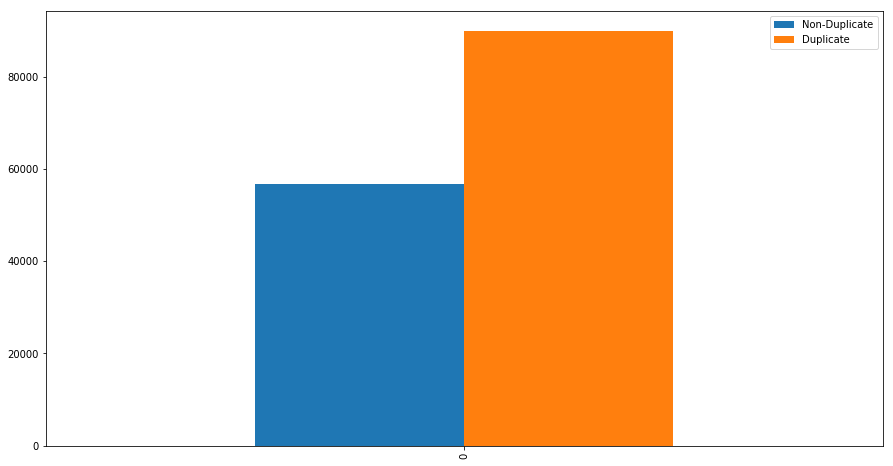

In [39]:
# assuming duplicated questions have a partial ratio from 75th percentile onwards
duplicate_df = pd.DataFrame([data[data['partial_ratio'] > 85]['is_duplicate'].value_counts().values[0], data[data['partial_ratio'] < 85]['is_duplicate'].value_counts().values[1]])
duplicate_df.index = ['Non-Duplicate', 'Duplicate']
# duplicate_df.T
duplicate_df.T.plot(kind='bar', figsize=(15,8))

Over 80000 data points rightly labelled according the partial ratio feature.

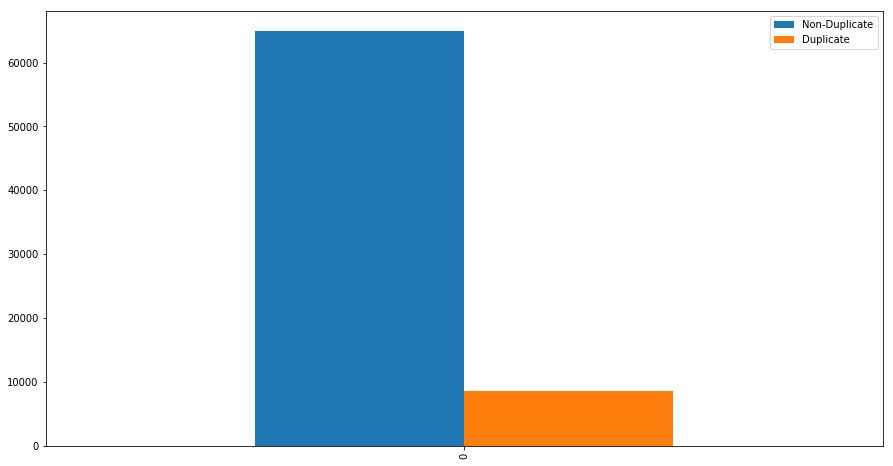

In [40]:
# assuming duplicated questions have a partial ratio in above 75th percentile
duplicate_df = pd.DataFrame([data[data['token_set_ratio'] > 92]['is_duplicate'].value_counts().values[0], data[data['partial_ratio'] < 92]['token_set_ratio'].value_counts().values[1]])
duplicate_df.index = ['Non-Duplicate', 'Duplicate']
# duplicate_df.T
duplicate_df.T.plot(kind='bar', figsize=(15,8))

More than 10000 data points wrongly labelled according the the token set ratio.

**WORD2VEC FEATURE EXTRACTION**



In [33]:
word2vec_file = 'glove.6B.300d.txt.word2vec'

In [34]:
model = KeyedVectors.load_word2vec_format(word2vec_file, binary=False)

In [36]:
def word_similarity(x1, x2):
    '''
    Check each word in a question pair against each other for similarity and squash it between 0 and 1.
    Hence, very similar questions have a scopre closer to one and vice versa.
    '''
    similarity = []
    for word1 in x1:
        for word2 in x2:
            try:
                similarity.append(model.similarity(word1, word2))
            except KeyError as e:
                continue
    return expit(sum(similarity))

In [37]:
data['word_similarity'] = data.apply(lambda x: word_similarity(x['question1'], x['question2']), axis=1)

In [38]:
unwanted_columns = ['question1', 'question2']

training_data = data.drop(unwanted_columns, axis=1)
X = training_data.drop(['is_duplicate'], axis=1)
Y = training_data['is_duplicate']

**Machine Learning Models with Word2Vec Feattures**

In [40]:
X_train, X_valid, y_train, y_valid = train_test_split(X, Y, test_size=0.30, random_state=42)

In [41]:
scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train)

In [42]:
scoring = make_scorer(log_loss, needs_proba=True, greater_is_better=False)

In [46]:
pipelines = []
pipelines.append(('ScaledLR', Pipeline([('Scaler', StandardScaler()), ('LR', LogisticRegression())])))
pipelines.append(('ScaledRF', Pipeline([('Scaler', StandardScaler()), ('RF', RandomForestClassifier())])))
pipelines.append(('ScaledXG', Pipeline([('Scaler', StandardScaler()), ('XG', XGBClassifier())])))

results = []
names = []

for name, model in pipelines:
    kfold = KFold(n_splits=10, random_state=42)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

ScaledLR: -0.532948 (0.002666)
ScaledRF: -0.978139 (0.031121)
ScaledXG: -0.491490 (0.002421)


The XGBClassifier was the better model here so it can further be tuned to get a better log loss score. RandomForestClassifier performed poorly because it does not work well with sparse datasets. The benchmark model is to get a log loss score below `0.4`.

In [47]:
# xgboostclassifier
scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train)

kfold = KFold(n_splits=10, random_state=42)

max_depth = [3, 4, 5, 6, 7, 8]
min_child_weight = [1, 2, 3, 4]
param_grid = dict(max_depth=max_depth, min_child_weight=min_child_weight)

model = XGBClassifier()

grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(scaled_X_train, y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.467980 using {'max_depth': 8, 'min_child_weight': 1}
-0.491531 (0.002413) with: {'max_depth': 3, 'min_child_weight': 1}
-0.491382 (0.002507) with: {'max_depth': 3, 'min_child_weight': 2}
-0.491456 (0.002597) with: {'max_depth': 3, 'min_child_weight': 3}
-0.491640 (0.002299) with: {'max_depth': 3, 'min_child_weight': 4}
-0.483421 (0.002538) with: {'max_depth': 4, 'min_child_weight': 1}
-0.483353 (0.002552) with: {'max_depth': 4, 'min_child_weight': 2}
-0.483352 (0.002591) with: {'max_depth': 4, 'min_child_weight': 3}
-0.483276 (0.002412) with: {'max_depth': 4, 'min_child_weight': 4}
-0.477563 (0.002503) with: {'max_depth': 5, 'min_child_weight': 1}
-0.477616 (0.002649) with: {'max_depth': 5, 'min_child_weight': 2}
-0.477764 (0.002562) with: {'max_depth': 5, 'min_child_weight': 3}
-0.477633 (0.002638) with: {'max_depth': 5, 'min_child_weight': 4}
-0.473465 (0.002548) with: {'max_depth': 6, 'min_child_weight': 1}
-0.473475 (0.002732) with: {'max_depth': 6, 'min_child_weight': 2}


The log loss score has improved. Maybe it can be further be improved with a better larger `max_depth` argument but I would make due with what I got and improve it later.

Lets add more features to see if the model improves. Next will be to generate the tf-idf vectorizer for the dataset.

In [48]:
# join question1 and question2 columns to one axis
train_data_q1, train_data_q2 = data[['question1']], data[['question2']]
print(f'Length of Question 1: {len(train_data_q1)}, \nLength of Question 2: {len(train_data_q2)} \nTotal: {len(train_data_q1)+len(train_data_q2)}')
train_data_q1.columns, train_data_q2.columns = ['question'], ['question'] 
train_q = pd.concat([train_data_q1, train_data_q2], ignore_index=True, axis=0)

Length of Question 1: 404290, 
Length of Question 2: 404290 
Total: 808580


In [49]:
train_q.head()

question
0  [step, step, guide, invest, share, market, india]
1               [story, kohinoor, kohinoor, diamond]
2  [increase, speed, internet, connection, using,...
3                          [mentally, lonely, solve]
4  [one, dissolve, water, quikly, sugar, salt, me...

In [50]:
# prepare question values for tfidfvectorizer
docs = []
for q in train_q.values:
    docs.append(*q)
docs

[['step', 'step', 'guide', 'invest', 'share', 'market', 'india'],
 ['story', 'kohinoor', 'kohinoor', 'diamond'],
 ['increase', 'speed', 'internet', 'connection', 'using', 'vpn'],
 ['mentally', 'lonely', 'solve'],
 ['one',
  'dissolve',
  'water',
  'quikly',
  'sugar',
  'salt',
  'methane',
  'carbon',
  'di',
  'oxide'],
 ['astrology', 'capricorn', 'sun', 'cap', 'moon', 'cap', 'rising', 'say'],
 ['buy', 'tiago'],
 ['good', 'geologist'],
 ['use', 'instead'],
 ['motorola', 'company', 'hack', 'charter', 'motorolla', 'dcx3400'],
 ['method', 'find', 'separation', 'slits', 'using', 'fresnel', 'biprism'],
 ['read', 'find', 'youtube', 'comments'],
 ['make', 'physics', 'easy', 'learn'],
 ['first', 'sexual', 'experience', 'like'],
 ['laws',
  'change',
  'status',
  'student',
  'visa',
  'green',
  'card',
  'us',
  'compare',
  'immigration',
  'laws',
  'canada'],
 ['would',
  'trump',
  'presidency',
  'mean',
  'current',
  'international',
  'master',
  'students',
  'f1',
  'visa'],
 ['

**TERM FREQUENCY - INVERSE DOCUMENT FREQUENCY (TF-IDF) FEATURE EXTRACTION**

In [51]:
def dummy_fun(doc):
    return doc

tfidf = TfidfVectorizer(
    analyzer='word',
    tokenizer=dummy_fun,
    preprocessor=dummy_fun,
    token_pattern=None)

tfidfv = tfidf.fit(docs)

In [52]:
tfidfv.vocabulary_

{'step': 87337,
 'guide': 39991,
 'invest': 47008,
 'share': 82813,
 'market': 55678,
 'india': 45409,
 'story': 87653,
 'kohinoor': 50705,
 'diamond': 26357,
 'increase': 45298,
 'speed': 86244,
 'internet': 46681,
 'connection': 21249,
 'using': 97223,
 'vpn': 99055,
 'mentally': 57046,
 'lonely': 53639,
 'solve': 85622,
 'one': 65053,
 'dissolve': 27321,
 'water': 99631,
 'quikly': 74643,
 'sugar': 88540,
 'salt': 79865,
 'methane': 57337,
 'carbon': 16498,
 'di': 26291,
 'oxide': 67131,
 'astrology': 9262,
 'capricorn': 16424,
 'sun': 88706,
 'cap': 16344,
 'moon': 59206,
 'rising': 78304,
 'say': 80449,
 'buy': 15582,
 'tiago': 92289,
 'good': 38951,
 'geologist': 38009,
 'use': 97149,
 'instead': 46328,
 'motorola': 59497,
 'company': 20617,
 'hack': 40381,
 'charter': 18001,
 'motorolla': 59498,
 'dcx3400': 24537,
 'method': 57346,
 'find': 34471,
 'separation': 82025,
 'slits': 84850,
 'fresnel': 36542,
 'biprism': 13000,
 'read': 75672,
 'youtube': 102972,
 'comments': 20456,


In [53]:
vectors = tfidfv.transform(docs)

#Use Truncated SVD for dimension reduction on the TFIDF matrix
trunc = TruncatedSVD(n_components=20, algorithm='randomized', n_iter=10, random_state=0)
trunc_vec = trunc.fit_transform(vectors)
tfidf_vec = pd.DataFrame(trunc_vec)

#Save processed tfidf vectors for later use
tfidf_vec.to_pickle('tfidf_vec.pkl')

In [54]:
# tfidf_vec = pd.DataFrame([vectors])
tfidf_vec

0             1             2             3             4   \
0       3.554628e-02  1.980797e-02  9.476206e-03 -4.349222e-02 -3.302893e-02   
1       2.004909e-03  6.691434e-04 -8.344218e-04 -1.691031e-03 -6.183989e-04   
2       1.567654e-02  1.875925e-02  1.806812e-03 -2.495301e-03  4.623172e-03   
3       2.355581e-03  4.127494e-03 -8.944469e-04 -2.437741e-03 -1.906283e-03   
4       1.069053e-02  1.779539e-02 -3.554730e-03 -1.837143e-02 -7.638443e-03   
5       2.987710e-03  4.603134e-03 -2.441945e-03 -4.728206e-03 -3.857766e-03   
6       1.659581e-02 -1.835091e-03 -4.013229e-04 -2.352247e-03 -2.973478e-03   
7       2.034374e-02  2.905063e-02 -4.926250e-03 -4.284774e-02 -4.290474e-03   
8       1.738771e-02  3.553512e-02 -2.268753e-02  7.157925e-03 -7.469877e-03   
9       8.061360e-03  2.656042e-03 -1.501270e-03 -5.457477e-03  1.495324e-03   
10      1.085362e-02  1.269406e-02 -6.126799e-03 -2.730167e-03 -2.389024e-03   
11      3.578328e-02  3.613392e-02  5.378537e-03 -2.985780e-03 -4.584066e-03   
12      1.175838e-01  1.116518e-01  1.831943e-01  3.612026e-02 -1.346377e-03   
13      3.776126e-02  7.304644e-02 -4.334343e-02 -1.064869e-01 -6.409527e-02   
14      1.710386e-02  2.286992e-02 -5.982072e-03 -3.189202e-02 -3.275351e-03   
15      2.592289e-02  5.671430e-02 -2.311940e-02 -8.532633e-02 -9.796042e-02   
16      4.233779e-03  1.123094e-02 -7.327523e-03 -6.899795e-03 -5.621608e-03   
17      2.084783e-02  3.236932e-02 -6.828685e-03 -3.501505e-02 -1.033969e-02   
18      4.321673e-02  2.006819e-01 -1.882357e-01  1.922401e-01  1.201749e-02   
19      1.772306e-01 -7.603970e-02 -1.154942e-02  2.579114e-02 -2.433900e-03   
20      5.345878e-03  1.426244e-02 -5.777030e-03 -1.111944e-02 -8.928302e-03   
21      1.303782e-02  2.600650e-02 -1.456829e-02 -2.456261e-02 -1.055404e-03   
22      7.959087e-02  3.863435e-01 -3.768719e-01  4.235214e-01  2.729601e-02   
23      9.353679e-03  2.206671e-02  1.023791e-02 -1.220579e-02 -1.013032e-03   
24      2.942436e-02  3.446552e-02 -1.788512e-02 -3.769579e-02 -1.953865e-02   
25      2.383952e-02  2.588028e-02 -7.520034e-03 -3.091253e-02  3.514552e-02   
26      1.575225e-02  2.726304e-03 -3.370591e-03 -4.206686e-03  3.216791e-03   
27      2.256183e-02  2.306296e-02  1.096746e-02 -1.583530e-02 -6.725136e-03   
28      5.488083e-01  2.440908e-01  6.123841e-01  2.169524e-01  9.006695e-02   
29      1.485620e-02  1.611057e-03 -3.219396e-03 -9.472903e-03  1.751240e-03   
...              ...           ...           ...           ...           ...   
808550  2.671772e-01 -1.074812e-01 -2.619010e-02  3.066109e-02 -6.766088e-04   
808551  1.460223e-02  5.796208e-03 -4.323123e-03 -4.354410e-03 -6.135410e-03   
808552  1.638941e-02 -5.842908e-03 -1.778843e-03  1.566389e-04  1.509720e-05   
808553  2.123691e-03  2.550071e-03 -3.794785e-04 -2.983860e-03 -1.746163e-03   
808554  4.767825e-02  1.063560e-01  1.413036e-01  2.180899e-02  3.162125e-03   
808555  3.776130e-02 -1.943056e-03  1.945179e-03 -8.598581e-03  8.827178e-03   
808556  3.506787e-02  4.394417e-02 -1.357216e-02 -3.808124e-02 -7.503982e-03   
808557  8.315997e-03  1.650316e-02 -2.823422e-03 -1.970195e-02 -2.052495e-02   
808558  8.068405e-03  4.774914e-03 -8.784939e-04 -6.421612e-03 -2.182519e-03   
808559  2.009332e-02  5.310532e-02 -2.665722e-02 -7.693333e-02 -4.955765e-02   
808560  8.810124e-03  1.216678e-02 -3.609612e-03 -1.573157e-02 -8.896804e-03   
808561  1.440605e-02  1.513723e-02 -1.861088e-04 -2.335693e-02 -1.345639e-02   
808562  3.489944e-02  1.085364e-01 -8.041355e-02 -3.488497e-02 -7.764213e-02   
808563  1.462710e-02  2.947539e-02 -9.161896e-03 -3.295054e-02 -3.587265e-02   
808564  7.604491e-03  1.173203e-02 -4.410687e-03 -1.337036e-02 -8.211689e-03   
808565  8.843895e-04  3.597800e-04 -9.214675e-05 -6.396139e-04  2.068135e-04   
808566  4.791843e-35 -3.014160e-33  1.158538e-32 -4.408604e-32 -5.708086e-32   
808567  4.271879e-02  1.535107e-01 -1.040896e-01 -6.814046e-02 -1.044273e-01   
808568  1.015282e-

In [55]:
#Add these TFIDF reduced vector "distance" as new features
label = data['is_duplicate']
vector_train_q1 = tfidf_vec[0:len(train_data_q1)].reset_index(drop=True)
vector_train_q2 = tfidf_vec[len(train_data_q1):].reset_index(drop=True)

In [56]:
tfidf_train_vector = np.abs(vector_train_q1.values-vector_train_q2.values)
tfidf_train_vector = pd.DataFrame(tfidf_train_vector)
tfidf_train_vector.head()

0         1         2         3         4         5         6   \
0  0.024785  0.014499  0.005289  0.039209  0.030550  0.074825  0.068535   
1  0.015926  0.031288  0.003161  0.044891  0.032086  0.027252  0.008122   
2  0.005597  0.012706  0.000999  0.001986  0.004950  0.000900  0.005752   
3  0.007461  0.007469  0.006136  0.005822  0.002102  0.010882  0.005465   
4  0.005218  0.011302  0.004071  0.022171  0.030810  0.024185  0.008516   

         7         8         9         10        11        12        13  \
0  0.047637  0.045847  0.036778  0.010183  0.044094  0.083496  0.033401   
1  0.006030  0.012963  0.012971  0.013387  0.015447  0.045706  0.012470   
2  0.000910  0.004397  0.002553  0.009677  0.004252  0.001365  0.011414   
3  0.001904  0.004542  0.000652  0.005222  0.013176  0.006512  0.005311   
4  0.018198  0.008911  0.023802  0.011349  0.025332  0.018339  0.009487   

         14        15        16        17        18        19  
0  0.048760  0.030577  0.008906  0.000151  0.009603  0.018060  
1  0.002271  0.046831  0.006964  0.015689  0.023785  0.059361  
2  0.003539  0.005577  0.000194  0.006401  0.009523  0.011032  
3  0.004124  0.004322  0.020819  0.007876  0.001799  0.026574  
4  0.006498  0.038974  0.003468  0.021700  0.039409  0.138443

In [57]:
new_data = pd.concat([data, tfidf_train_vector], axis=1)
new_data.head()

question1  \
0  [step, step, guide, invest, share, market, india]   
1               [story, kohinoor, kohinoor, diamond]   
2  [increase, speed, internet, connection, using,...   
3                          [mentally, lonely, solve]   
4  [one, dissolve, water, quikly, sugar, salt, me...   

                                           question2  is_duplicate  len_q1  \
0         [step, step, guide, invest, share, market]             0       7   
1  [would, happen, indian, government, stole, koh...             0       4   
2         [internet, speed, increased, hacking, dns]             0       6   
3  [find, remainder, math, twentythree, twentyfou...             0       3   
4                [fish, would, survive, salt, water]             0      10   

   len_q2  diff_len  common_words  len_char_q1  len_char_q2  ratio    ...     \
0       6         1             5           15           15     92    ...      
1       9        -5             2           12           20     59    ...      
2       5         1             2           14           13     55    ...      
3       8        -5             0           10           17     20    ...      
4       5         5             2           22           14     43    ...      

         10        11        12        13        14        15        16  \
0  0.010183  0.044094  0.083496  0.033401  0.048760  0.030577  0.008906   
1  0.013387  0.015447  0.045706  0.012470  0.002271  0.046831  0.006964   
2  0.009677  0.004252  0.001365  0.011414  0.003539  0.005577  0.000194   
3  0.005222  0.013176  0.006512  0.005311  0.004124  0.004322  0.020819   
4  0.011349  0.025332  0.018339  0.009487  0.006498  0.038974  0.003468   

         17        18        19  
0  0.000151  0.009603  0.018060  
1  0.015689  0.023785  0.059361  
2  0.006401  0.009523  0.011032  
3  0.007876  0.001799  0.026574  
4  0.021700  0.039409  0.138443  

[5 rows x 38 columns]

In [ ]:
# new_data.to_csv('finaldata.csv')

In [58]:
unwanted_columns = ['question1', 'question2']

tfidf_training_data = new_data.drop(unwanted_columns, axis=1)
X = tfidf_training_data.drop(['is_duplicate'], axis=1)
Y = tfidf_training_data['is_duplicate']

In [59]:
X_train, X_valid, y_train, y_valid = train_test_split(X, Y, test_size=0.30, random_state=42)

In [60]:
pipelines = []
pipelines.append(('ScaledLR', Pipeline([('Scaler', StandardScaler()), ('LR', LogisticRegression())])))
pipelines.append(('ScaledRF', Pipeline([('Scaler', StandardScaler()), ('RF', RandomForestClassifier())])))
pipelines.append(('ScaledXG', Pipeline([('Scaler', StandardScaler()), ('XG', XGBClassifier())])))

results = []
names = []

for name, model in pipelines:
    kfold = KFold(n_splits=10, random_state=42)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

ScaledLR: -0.520244 (0.002672)
ScaledRF: -0.782523 (0.017344)
ScaledXG: -0.480573 (0.002681)


Over here with our new features all three model improve. Yet again the XGBClassifier performed better than all the others hence we can further tune is with same hyperparameters as before.

In [62]:
# xgboostclassifier
scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train)

kfold = KFold(n_splits=10, random_state=42)

max_depth = [3, 4, 5, 6, 7, 8]
min_child_weight = [1, 2, 3, 4]
param_grid = dict(max_depth=max_depth, min_child_weight=min_child_weight)

model = XGBClassifier()

grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(scaled_X_train, y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.447165 using {'max_depth': 8, 'min_child_weight': 1}
-0.480679 (0.002515) with: {'max_depth': 3, 'min_child_weight': 1}
-0.480633 (0.002740) with: {'max_depth': 3, 'min_child_weight': 2}
-0.480638 (0.002610) with: {'max_depth': 3, 'min_child_weight': 3}
-0.480694 (0.002505) with: {'max_depth': 3, 'min_child_weight': 4}
-0.471082 (0.002407) with: {'max_depth': 4, 'min_child_weight': 1}
-0.471013 (0.002593) with: {'max_depth': 4, 'min_child_weight': 2}
-0.470857 (0.002262) with: {'max_depth': 4, 'min_child_weight': 3}
-0.471068 (0.002653) with: {'max_depth': 4, 'min_child_weight': 4}
-0.463970 (0.002792) with: {'max_depth': 5, 'min_child_weight': 1}
-0.464035 (0.002525) with: {'max_depth': 5, 'min_child_weight': 2}
-0.463936 (0.002541) with: {'max_depth': 5, 'min_child_weight': 3}
-0.464001 (0.002473) with: {'max_depth': 5, 'min_child_weight': 4}
-0.457426 (0.002613) with: {'max_depth': 6, 'min_child_weight': 1}
-0.457420 (0.002479) with: {'max_depth': 6, 'min_child_weight': 2}


An increase in 0.02 from 0.467980 to 0.447165 with the new features from the tf-idfvectorizer. As mentioned above likely to do better with a higher `max_depth` argument. Lets go ahead and see how to performes on the validation set

In [65]:
# prepare the final model
scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train)

model = XGBClassifier(max_depth=8, min_child_weight=1, random_state=42)
model.fit(scaled_X_train, y_train)

scaled_X_valid = scaler.transform(X_valid)
predictions = model.predict_proba(scaled_X_valid)
print(log_loss(y_valid, predictions))

0.449716341293


It performed well. No overfitting here. The model can be improved with better hyperparameter tuning. Maybe it can be improved with a neural network which is tackled in the Recurrent Neural Network (LSTM).ipynb file.